In [1]:
from lib_fetaure_analysis import Features
from defect_analysis import Test
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import torch as Torch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from ultralytics import YOLO
from lib.lib_utils import Utils 
import seaborn as sns
import seaborn.objects as so


## Generazione immagini da .xyz 

In [2]:
#trasformazione .xyz to .png
Utils.from_xyz_to_png(
    Path('/home/gabro/GrapheDetectProject/data.xyz/subset_xyz'), 
    Path('/home/gabro/GrapheDetectProject/immPerInferenza'), 
    2000)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2000
Immagini salvate in: /home/gabro/GrapheDetectProject/immPerInferenza


## Inferenza yolo e crop difetti

In [3]:
# Load a model
# model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("/home/gabro/GrapheDetectProject/best_100_campioni_new.pt")  # load a pretrained model (recommended for training)
#fa l'inferenza su una cartella di campioni con yolo salvandone le box su un'altra cartella
Utils.crop_from_folder("/home/gabro/GrapheDetectProject/immPerInferenza", "/home/gabro/GrapheDetectProject/cartellaCrop", model)


image 1/1 /home/gabro/GrapheDetectProject/immPerInferenza/graphene_135234_bonds.png: 640x640 3 defects, 237.8ms
Speed: 3.8ms preprocess, 237.8ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/gabro/GrapheDetectProject/immPerInferenza/graphene_79008_bonds.png: 640x640 1 defect, 164.3ms
Speed: 2.2ms preprocess, 164.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/gabro/GrapheDetectProject/immPerInferenza/graphene_115798_bonds.png: 640x640 3 defects, 171.8ms
Speed: 0.9ms preprocess, 171.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/gabro/GrapheDetectProject/immPerInferenza/graphene_247956_bonds.png: 640x640 1 defect, 186.9ms
Speed: 1.2ms preprocess, 186.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/gabro/GrapheDetectProject/immPerInferenza/graphene_33887_bonds.png: 640x640 1 defect, 191.1ms
Speed: 1.5ms preprocess, 191.1ms inference, 1.2m

Crop dei difetti salvati in: /home/gabro/GrapheDetectProject/cartellaCrop


## Evidenzia i difetti 

In [4]:
#per ogni crop in carttelaCrop/ ne produce una copia su cartellaTrash/ in cui ne si enfatizza l'area
Utils.from_crops_to_thresh('/home/gabro/GrapheDetectProject/cartellaCrop/', '/home/gabro/GrapheDetectProject/cartellaTrash')

Nuove immagini (area evidenziata) salvate in: /home/gabro/GrapheDetectProject/cartellaTrash


## Produzione contonri, calcolo features e creazione dataframe 

ERRORE: Non sono stati trovati contorni in: 
/home/gabro/GrapheDetectProject/cartellaTrash/graphene_151490_bonds_cropped_box_2_thresh_.png
Vengono assunti 0 i parametri.
ERRORE: Non sono stati trovati contorni in: 
/home/gabro/GrapheDetectProject/cartellaTrash/graphene_258965_bonds_cropped_box_1_thresh_.png
Vengono assunti 0 i parametri.
ERRORE: Non sono stati trovati contorni in: 
/home/gabro/GrapheDetectProject/cartellaTrash/graphene_82166_bonds_cropped_box_1_thresh_.png
Vengono assunti 0 i parametri.
ERRORE: Non sono stati trovati contorni in: 
/home/gabro/GrapheDetectProject/cartellaTrash/graphene_21096_bonds_cropped_box_1_thresh_.png
Vengono assunti 0 i parametri.
ERRORE: Non sono stati trovati contorni in: 
/home/gabro/GrapheDetectProject/cartellaTrash/graphene_39984_bonds_cropped_box_1_thresh_.png
Vengono assunti 0 i parametri.
ERRORE: Non sono stati trovati contorni in: 
/home/gabro/GrapheDetectProject/cartellaTrash/graphene_179283_bonds_cropped_box_2_thresh_.png
Vengono assunt

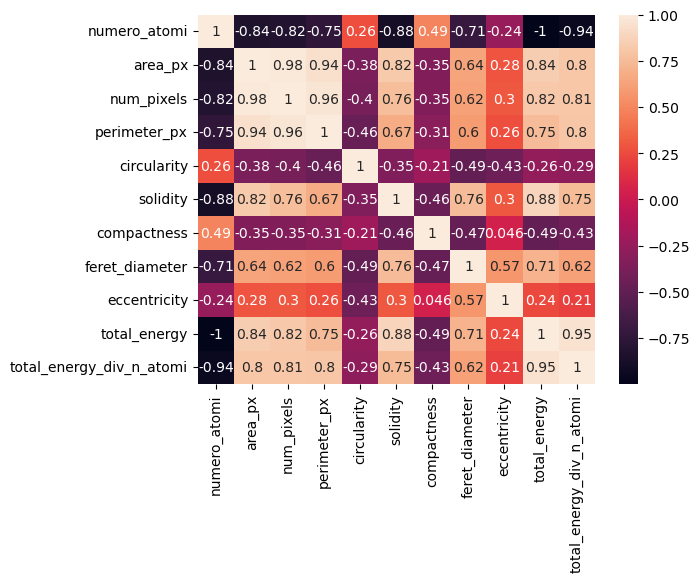

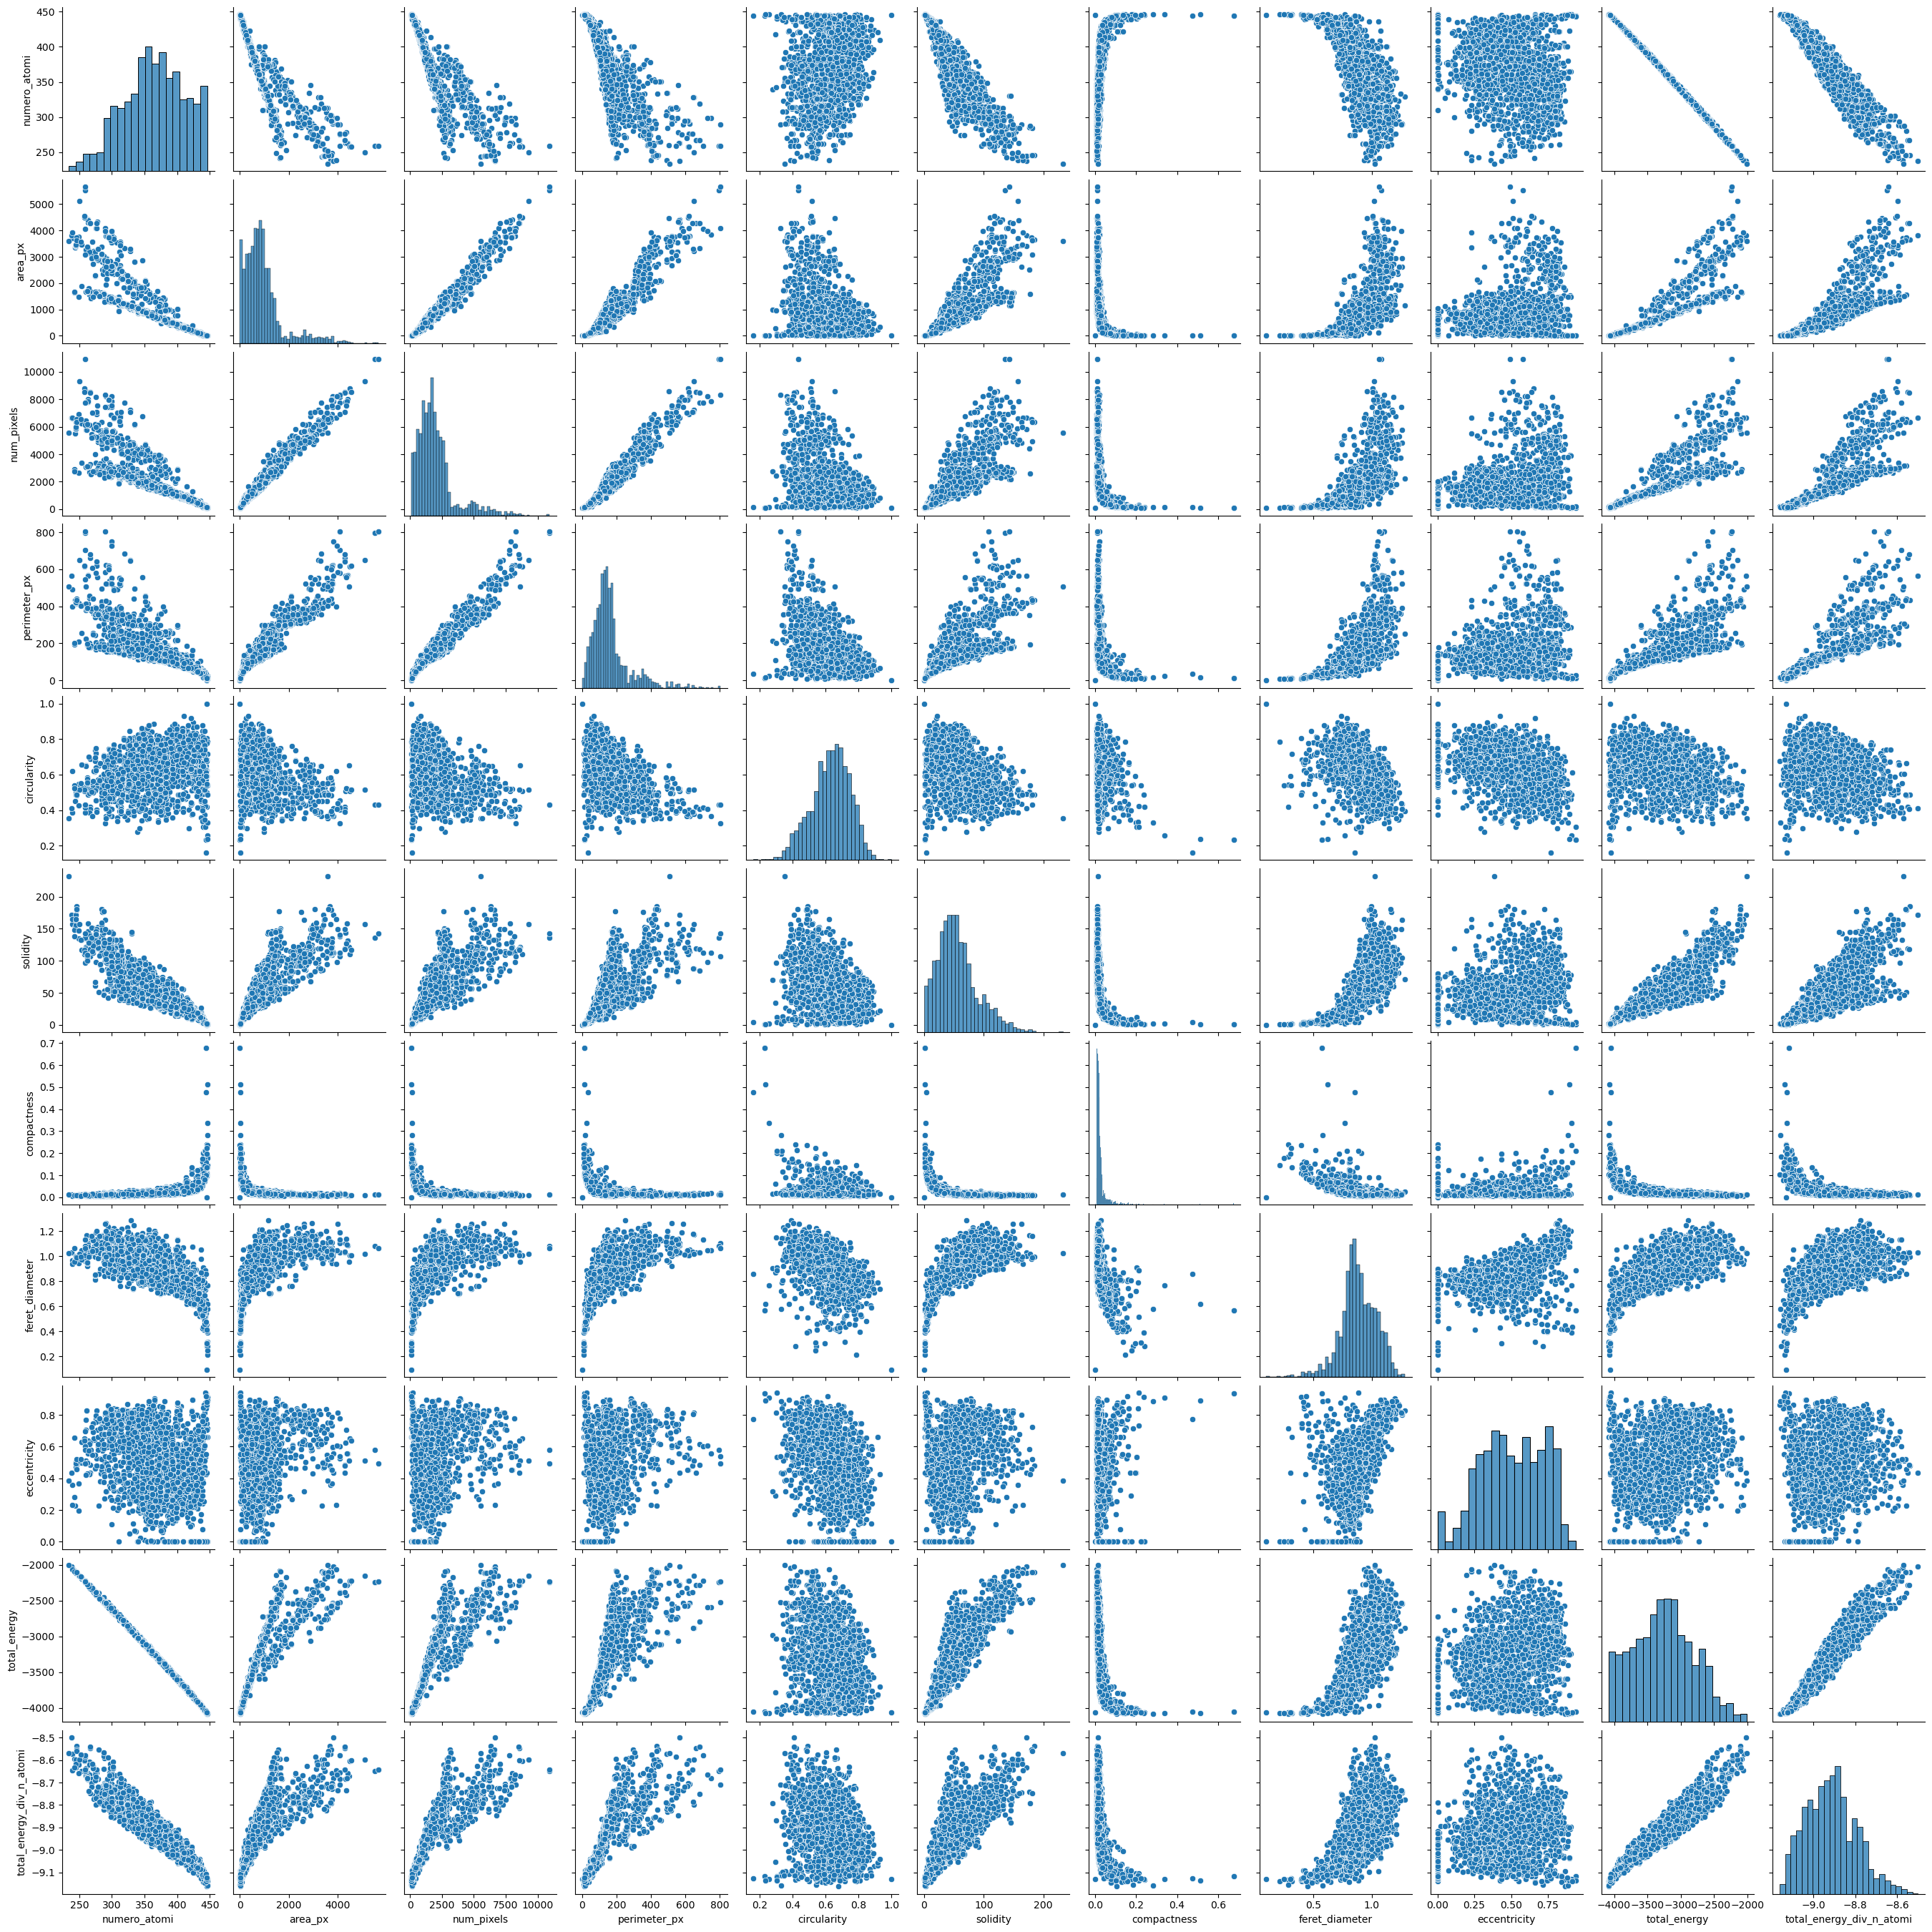

In [5]:
pathCartellaTresh = Path('/home/gabro/GrapheDetectProject/cartellaTrash')
pathCartellaContours = Path('/home/gabro/GrapheDetectProject/contours')
shapes = Features.from_thresh_to_contours_print_features(pathCartellaTresh,pathCartellaContours)
##stampa le feature estratte per ogni difetto analizzato 
# for shape in shapes:
#     print("Shape features:")
#     for key in shape:
#         print(key, ' : ', shape[key])
#     print()

boxes_df = pd.DataFrame.from_records(shapes)
boxes_df.to_csv('/home/gabro/GrapheDetectProject/dataframes/box_dataframe.csv')
print("old df")
print(boxes_df)

# raggruppa le righe in base al nome dell'immagine e calcola la somma dell'area, perimetro, numero atomi, numero pixel 
# e la media pesata per l'area degli altri parametri
grouped_df = boxes_df.groupby('nome_imm').apply(lambda x: pd.Series({
    "numero_atomi": x['numero_atomi'].max(),    #notare come i due volori del numero di atomi sono guali, scelgo il massimo solo per sceglierne uno a caso.
    'area_px': x['area_px'].sum(),  #somma semplice per area e perimetro 
    # 'area_px_div_n_atomi': x['area_px_div_n_atomi'].sum(), 
    'num_pixels': x['num_pixels'].sum(),
    'perimeter_px': x['perimeter_px'].sum(),
    # 'perimeter_px_div_n_atomi': x['perimeter_px_div_n_atomi'].sum(), 
    'circularity': (x['circularity'] * x['area_px']).sum() / x['area_px'].sum(),    #somma pesata per l'area per tutti gli altri 
    'solidity': (x['solidity'] * x['area_px']).sum() / x['area_px'].sum(),
    'compactness': (x['compactness'] * x['area_px']).sum() / x['area_px'].sum(),
    'feret_diameter': (x['feret_diameter'] * x['area_px']).sum() / x['area_px'].sum(),
    'eccentricity': (x['eccentricity'] * x['area_px']).sum() / x['area_px'].sum(),
}))
# salvo il nuovo dataframe 
grouped_df.to_csv('/home/gabro/GrapheDetectProject/dataframes/groupedDataframe.csv')   
print("-----------------------------------------------------------------------------")
print("grouped dataframe")
# print(groupedDf)

# aggiungo total_energy facebdo il merge dal dataset dataset_graphene.csv
total_energy_dataset_df = pd.read_csv("/home/gabro/GrapheDetectProject/dataframes/dataset_graphene.csv")
merged_df = grouped_df.merge(total_energy_dataset_df[['file_name', 'total_energy']], left_on='nome_imm', right_on='file_name')
merged_df = merged_df.drop('file_name', axis=1) #droppo la prima colonna che rappresenta il nome, non vogliamo parametri non numerici 

merged_df = merged_df.assign(total_energy_div_n_atomi=merged_df["total_energy"] / merged_df["numero_atomi"])    #aggiungo una colonna total_energy_div_n_atomi calcolandola a posteriori 

# salvo e stampo il dataframe finale  
merged_df.to_csv('/home/gabro/GrapheDetectProject/dataframes/energy_dataframe.csv')
print(merged_df)

# stampo heatmap 
corr = merged_df.corr()
sns.heatmap(corr, annot=True)

# stampo basic correlogram
sns.pairplot(merged_df)
plt.show()


## Predittore total_energy

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import scipy


## Prendo i dati dal dataframe Pandas e li converto nel giusto formato

In [7]:
# dataRegression = merged_df[["numero_atomi" , "area_px"]].values #una colonna per ogni feature, una riga per ogni campione 
featuresList = [ "area_px", "num_pixels", "circularity", "solidity", "compactness", "feret_diameter", "eccentricity"]
# featuresList = [ "area_px", "circularity", "solidity", "compactness", "feret_diameter", "eccentricity"]
# featuresList = [ "area_px"]
dataRegression = merged_df[[ "area_px", "num_pixels", "circularity", "solidity", "compactness", "feret_diameter", "eccentricity"]].values
# dataRegression = merged_df[["area_px", "circularity", "solidity", "compactness", "feret_diameter", "eccentricity"]].values
# dataRegression = merged_df[[ "area_px"]].values

targetRegression = merged_df["total_energy"].values.flatten() #array con tutti i valori raget total_energy
targetRegression

X = dataRegression
y = targetRegression

print(X.shape)
print(y.shape)

#creo una copia dei dati normalizzata 
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

scaler2 = MinMaxScaler()
y_norm = scaler2.fit_transform(y.reshape(-1, 1))


featuresList

(1985, 7)
(1985,)


['area_px',
 'num_pixels',
 'circularity',
 'solidity',
 'compactness',
 'feret_diameter',
 'eccentricity']

## Splitto il dataset e faccio tuning degli hyperparametri

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    # X_norm, y_norm, test_size=0.1, random_state=13
    X, y, test_size=0.1, random_state=13
)

params = {
    "n_estimators": 500,
    "max_depth": 20,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}


## Scelgo il regressore e la funzione di costo

In [9]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 5262.5476


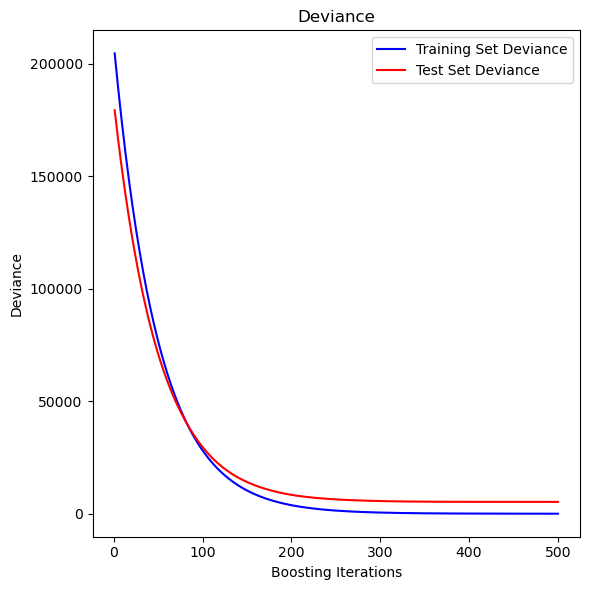

In [10]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

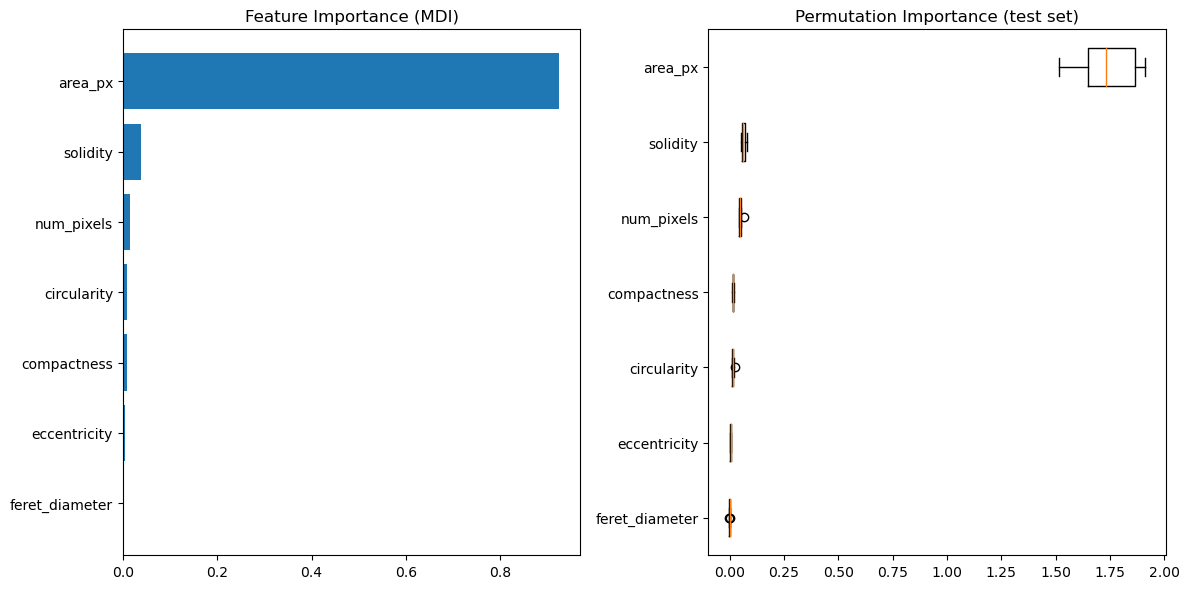

In [11]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(featuresList)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(featuresList)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()  
plt.show()

# Predizioni contro valori reali

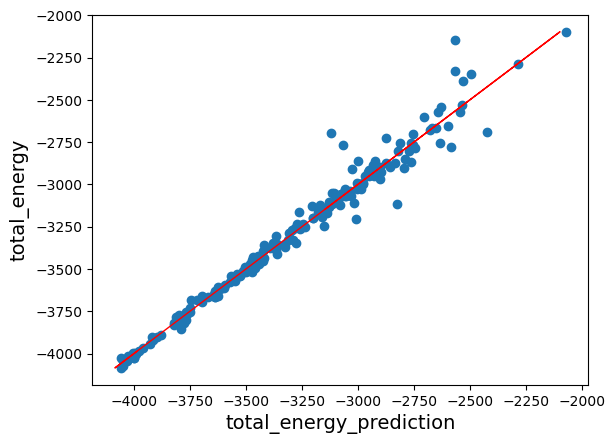

In [12]:
plt.scatter(y_pred, y_test)
# plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test,  color='red', linewidth=1)

plt.xlabel("total_energy_prediction", fontsize=14)
plt.ylabel("total_energy", fontsize = 14)
plt.show()


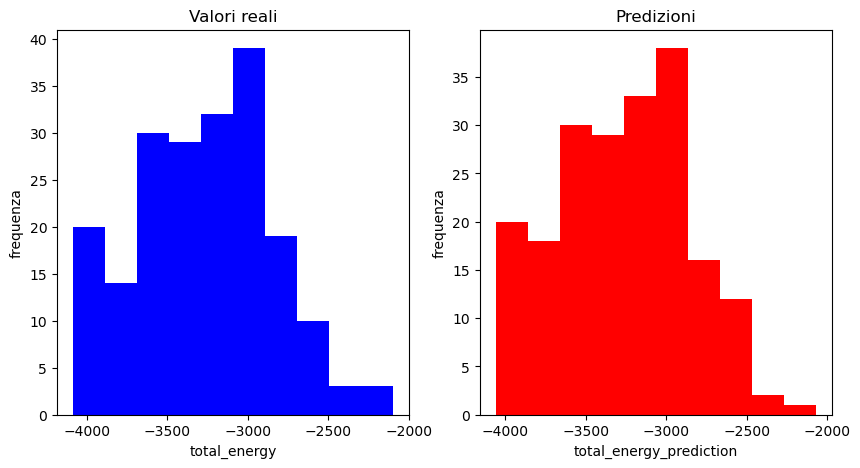

In [24]:

# Crea la figura e i due assi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Istogramma 1
# ax1.hist(y_test, bins=5, weights=y_test, color='blue')
ax1.hist(y_test, bins=10, color='blue')

ax1.set_xlabel('total_energy')
ax1.set_ylabel('frequenza')
ax1.set_title('Valori reali')

# Istogramma 2
# ax2.hist(y_pred, bins=5, weights=y_pred, color='red')
ax2.hist(y_pred, bins=10, color='red')
ax2.set_xlabel('total_energy_prediction')
ax2.set_ylabel('frequenza')
ax2.set_title('Predizioni')

# Mostra il grafico
plt.show()


In [19]:
# t - test
res = scipy.stats.ttest_ind(y_test, y_pred, 
                      equal_var=True)

display(res)

Ttest_indResult(statistic=0.08220925581739036, pvalue=0.9345218493265913)

# Predizioni e confronto con valori target

In [14]:
print("Target total_energy: ")
print(y_test[1:10])
print("Predicted total_energy: ")
print(reg.predict(X_test[1:10]))
print("Error: ")
print(y_test[1:10]-reg.predict(X_test[1:10]))


Target total_energy: 
[    -2284.8     -2910.9     -2570.9     -3649.1     -2851.2     -3828.1     -2928.5     -4044.1     -3536.9]
Predicted total_energy: 
[      -2283     -2910.7     -2542.8     -3644.4     -2791.4     -3819.2     -2952.5     -4049.8     -3536.3]
Error: 
[    -1.7482    -0.21449     -28.075     -4.7009     -59.861     -8.9015      23.976       5.697    -0.63399]


# R^2 score 

In [15]:
reg.score(X_test, y_test)

0.9711437904543666

In [13]:
reg.staged_predict(X)

<generator object GradientBoostingRegressor.staged_predict at 0x7f4ea7d78e40>